# Example FlowSOM Pipeline


This vignette describes a protocol for analyzing high-dimensional cytometry
data using FlowSOM, a clustering and visualization algorithm based
on a self-organizing map (SOM). FlowSOM is used to distinguish cell populations
from cytometry data in an unsupervised way and can help to gain deeper insights
in fields such as immunology and oncology.


## Loading in the data

FlowSOM handles different inputs, such as an anndata object by pytometry or a filepath. For this purpose we will make use of an anndata object. This allows
easier preprocessing. Note that this requires also installing the [pytometry](https://github.com/scverse/pytometry) package (version > 0.1.5) with e.g. `pip install pytometry`.


In [41]:
# Import modules
import flowsom as fs
import pytometry as pm
import scanpy as sc
import csv
import numpy as np
import matplotlib.pyplot as plt

# set default plotting parameters
plt.rcParams["figure.figsize"] = (6.5, 4.8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 10

In [42]:
# Load data
ff = fs.io.read_FCS("../../tests/data/not_preprocessed.fcs")
ff

AnnData object with n_obs × n_vars = 19225 × 18
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta'

We can get an overview of the most important data in our anndata object by using `var`. All the metadata is stored in a dictionary at `ff.uns["meta]`


In [43]:
ff.var

n            channel marker  $PnB $PnE  $PnG    $PnR $PnV
Time         1               Time           32  0,0  0.01  262144     
FSC-A        2              FSC-A           32  0,0   1.0  262144  280
FSC-H        3              FSC-H           32  0,0   1.0  262144  280
FSC-W        4              FSC-W           32  0,0   1.0  262144  280
SSC-A        5              SSC-A           32  0,0   1.0  262144  280
SSC-H        6              SSC-H           32  0,0   1.0  262144  280
SSC-W        7              SSC-W           32  0,0   1.0  262144  280
GFP          8             FITC-A    GFP    32  0,0   1.0  262144  412
CD8          9     Pacific Blue-A    CD8    32  0,0   1.0  262144  417
l/d         10           AmCyan-A    l/d    32  0,0   1.0  262144  496
Qdot 605-A  11         Qdot 605-A           32  0,0   1.0  262144  588
TCRyd       12              APC-A  TCRyd    32  0,0   1.0  262144  597
CD45        13  Alexa Fluor 700-A   CD45    32  0,0   1.0  262144  492
TCRb        14          APC-Cy7-A   TCRb    32  0,0   1.0  262144  511
NK1/1       15               PE-A  NK1/1    32  0,0   1.0  262144  505
CD4         16     PE-Texas Red-A    CD4    32  0,0   1.0  262144  560
CD19        17           PE-Cy5-A   CD19    32  0,0   1.0  262144  593
CD3         18           PE-Cy7-A    CD3    32  0,0   1.0  262144  588

In [44]:
ff.uns["meta"].keys()

dict_keys(['__header__', '$BEGINANALYSIS', '$BEGINDATA', '$BEGINSTEXT', '$BTIM', '$BYTEORD', '$DATATYPE', '$DATE', '$ENDANALYSIS', '$ENDDATA', '$ENDSTEXT', '$ETIM', '$FIL', '$INST', '$MODE', '$NEXTDATA', '$PAR', '$SRC', '$SYS', '$TIMESTEP', '$TOT', 'APPLY COMPENSATION', 'AUTOBS', 'CREATOR', 'EXPERIMENT NAME', 'EXPORT TIME', 'EXPORT USER NAME', 'FCSversion', 'FILENAME', 'flowCore_$P10Rmax', 'flowCore_$P10Rmin', 'flowCore_$P11Rmax', 'flowCore_$P11Rmin', 'flowCore_$P12Rmax', 'flowCore_$P12Rmin', 'flowCore_$P13Rmax', 'flowCore_$P13Rmin', 'flowCore_$P14Rmax', 'flowCore_$P14Rmin', 'flowCore_$P15Rmax', 'flowCore_$P15Rmin', 'flowCore_$P16Rmax', 'flowCore_$P16Rmin', 'flowCore_$P17Rmax', 'flowCore_$P17Rmin', 'flowCore_$P18Rmax', 'flowCore_$P18Rmin', 'flowCore_$P1Rmax', 'flowCore_$P1Rmin', 'flowCore_$P2Rmax', 'flowCore_$P2Rmin', 'flowCore_$P3Rmax', 'flowCore_$P3Rmin', 'flowCore_$P4Rmax', 'flowCore_$P4Rmin', 'flowCore_$P5Rmax', 'flowCore_$P5Rmin', 'flowCore_$P6Rmax', 'flowCore_$P6Rmin', 'flowCore_

Additionaly we can read in a csv file as well.


In [45]:
ff_csv = fs.io.read_csv("../../tests/data/fcs.csv")
ff_csv

AnnData object with n_obs × n_vars = 19225 × 18
    var: 'n', 'channel', 'marker'

The `FlowSOM` function accepts an anndata object or a filepath to a fcs or csv file. The `FlowSOM` function will return a `FlowSOM` mudata object. This object contains all the information about the SOM and the clustering.


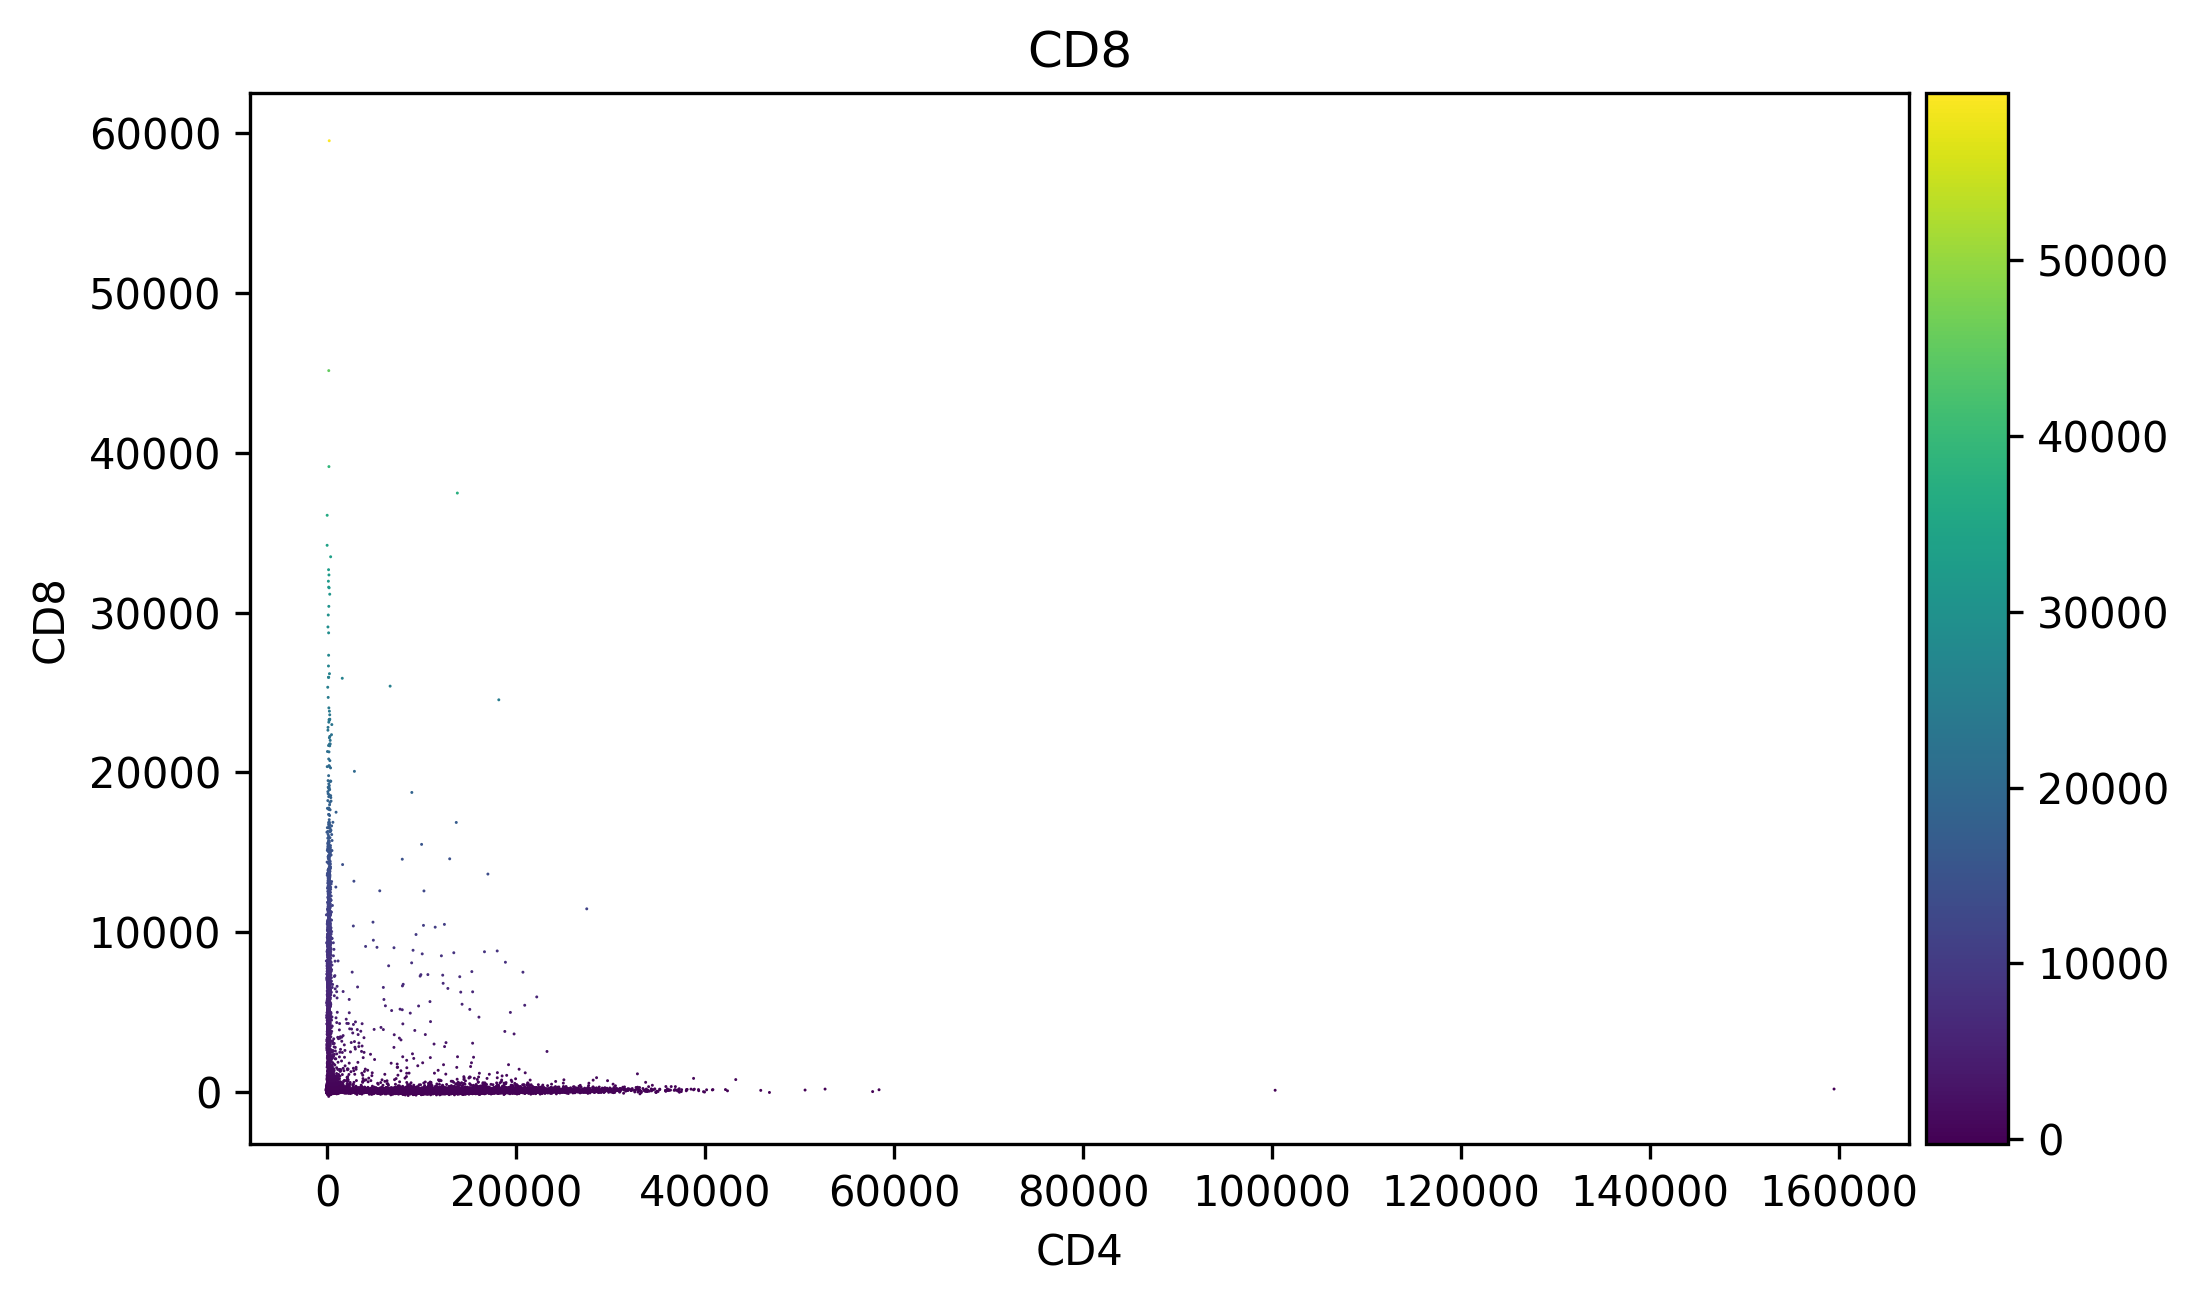

In [46]:
# Visualize data
sc.pl.scatter(ff, x="CD4", y="CD8", color="CD8", size=2)

## Preprocessing

We start with compensating the data and then we transform
the data with the logicle function. For CyTOF data an arcsinh transformation is
preferred which is also found in the pytometry package. Besides
compensation and transformation, we also recommend cleaning the data by removing
margin events and by using cleaning algorithms.


In [47]:
# Compensate
ff_comp = pm.pp.compensate(ff, inplace=False)

cols_to_use = [8, 11, 13, 14, 15, 16, 17]
colnames_to_use = ff_comp[:, cols_to_use].var_names.tolist()
colnames_to_use

['CD8', 'TCRyd', 'TCRb', 'NK1/1', 'CD4', 'CD19', 'CD3']

In [48]:
# Transform
ff_t = pm.tl.normalize_autologicle(ff_comp, channels=colnames_to_use, inplace=False)

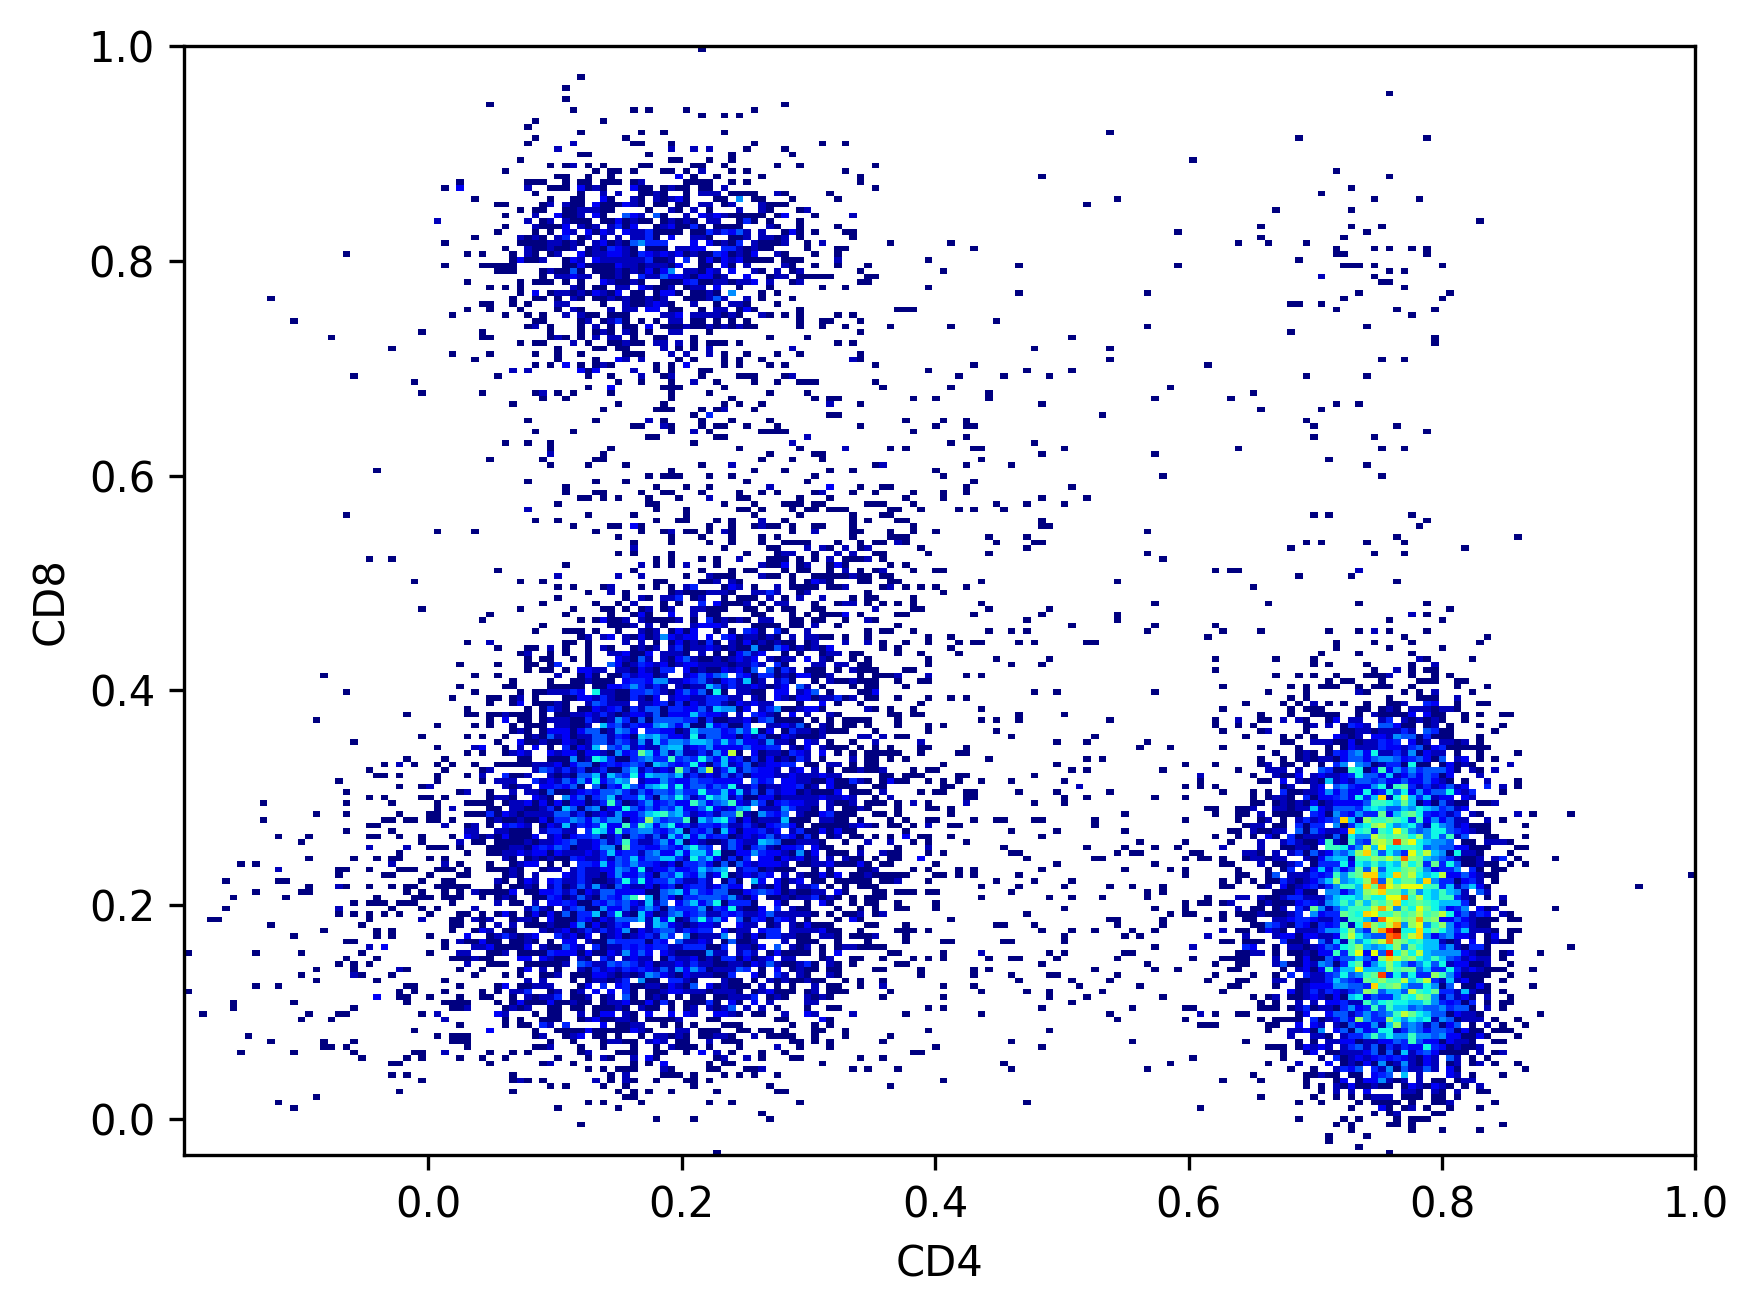

In [49]:
# Visualize data
ax = plt.hist2d(ff_t[:, "CD4"].X.flatten(), ff_t[:, "CD8"].X.flatten(), bins=200, cmin=1, cmap="jet")
plt.xlabel("CD4")
plt.ylabel("CD8")
plt.show()

# FlowSOM

The easiest way to use this package is using the wrapper function
FlowSOM, although it has less options than using the underlying functions separately. It holds the data in a MuData object, of which the first
modality is the cell data and the second modality is the cluster data. We will
cluster the data with a 10 x 10 SOM grid and 10 metaclusters. Notice that due to the
just-in-time compilation of numba, the first run of FlowSOM can take a while and
the subsequent runs will be much faster. We also set the seed here to make sure the analysis is deterministic and reproducible.

In [50]:
fsom = fs.FlowSOM(ff_t.copy(), cols_to_use=cols_to_use, n_clusters=10, xdim=10, ydim=10, seed=42)

2025-04-17 09:14:40.672 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-04-17 09:14:40.674 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-04-17 09:14:40.915 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


We can inspect the underlying model and can see it's like any other scikit-learn model. The FlowSOM estimator first overclusters using a `cluster_model` (Self-Organizing Map). Then it uses a `metacluster_model` (Consensus Agglomerative Clustering) to merge the clusters into metaclusters.

In [51]:
fsom.model

FlowSOMEstimator(cluster_model=SOMEstimator(codes=array([[ 0.19228934,  0.1865745 ,  0.23266686,  0.87238413,  0.05209107,
         0.3103338 ,  0.21093693],
       [ 0.37591392,  0.26387554,  0.21212712,  0.5848203 ,  0.21481907,
         0.26141116,  0.21131037],
       [ 0.428116  ,  0.27063912,  0.32987905,  0.46879607,  0.3014614 ,
         0.24979484,  0.21359852],
       [ 0.71539164,  0.25424176,  0.22920464,  0.38272676,  0.49828213,
         0.2463...
       [ 0.16985969,  0.12226646,  0.56166893,  0.25476876,  0.7380235 ,
         0.40652   ,  0.7086935 ],
       [ 0.27684072,  0.16656815,  0.6013744 ,  0.11409374,  0.7604119 ,
         0.36639097,  0.735394  ],
       [ 0.1659379 ,  0.27120367,  0.5247936 ,  0.12309174,  0.7345894 ,
         0.2421986 ,  0.67283285],
       [ 0.2248714 ,  0.31179267,  0.61458   ,  0.05833715,  0.773493  ,
         0.13654871,  0.74112475]], dtype=float32),
                                            seed=42),
                 metacluster_model=ConsensusCluster(K=10, n_clusters=10))

The output is stored in a MuData object, containing two AnnData object: `cell_data` (n_cells x n_features) and `cluster_data` (n_SOM_nodes x n_features).

In [52]:
fsom.mudata

MuData object with n_obs × n_vars = 0 × 0
  2 modalities
    cell_data:	19225 x 18
      obs:	'clustering', 'distance_to_bmu', 'metaclustering'
      var:	'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV', 'pretty_colnames', 'markers', 'channels', 'cols_used'
      uns:	'meta', 'n_nodes', 'n_metaclusters'
      layers:	'original'
    cluster_data:	100 x 18
      obs:	'percentages', 'metaclustering'
      uns:	'xdim', 'ydim', 'outliers', 'metacluster_MFIs', 'graph'
      obsm:	'cv_values', 'sd_values', 'mad_values', 'codes', 'grid', 'layout'

We can access the cell data and the cluster data with the `get_cell_data()` and
`get_cluster_data()` functions.

The _cell data_ is an anndata object that contains
the original cell data. As observations, we find the clustering, metaclustering
and distance to best matching unit per cell. In var, we find the pretty colnames,
i.e. a combination of markers and channels, the markers, the channels and a
boolean mask of the columns used for clustering. n_nodes and n_metaclusters in
uns contain the number of clusters and metaclusters respectively.


In [53]:
fsom.get_cell_data()

AnnData object with n_obs × n_vars = 19225 × 18
    obs: 'clustering', 'distance_to_bmu', 'metaclustering'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV', 'pretty_colnames', 'markers', 'channels', 'cols_used'
    uns: 'meta', 'n_nodes', 'n_metaclusters'
    layers: 'original'

The _cluster data_ contains the original median values per cluster per marker.
In obsm, we find the cv values, sd values, mad values, coordinates of the nodes,
coordinates of the the grid and the coordinates of the MST layout.
The xdim, ydim, outliers, igraph object and metacluster MFIs can be found in uns.


In [54]:
fsom.get_cluster_data()

AnnData object with n_obs × n_vars = 100 × 18
    obs: 'percentages', 'metaclustering'
    uns: 'xdim', 'ydim', 'outliers', 'metacluster_MFIs', 'graph'
    obsm: 'cv_values', 'sd_values', 'mad_values', 'codes', 'grid', 'layout'

In [55]:
fsom.get_cell_data().var

n            channel marker  $PnB $PnE  $PnG    $PnR $PnV  \
Time                1               Time           32  0,0  0.01  262144        
FSC-A               2              FSC-A           32  0,0   1.0  262144  280   
FSC-H               3              FSC-H           32  0,0   1.0  262144  280   
FSC-W               4              FSC-W           32  0,0   1.0  262144  280   
SSC-A               5              SSC-A           32  0,0   1.0  262144  280   
SSC-H               6              SSC-H           32  0,0   1.0  262144  280   
SSC-W               7              SSC-W           32  0,0   1.0  262144  280   
FITC-A              8             FITC-A    GFP    32  0,0   1.0  262144  412   
Pacific Blue-A      9     Pacific Blue-A    CD8    32  0,0   1.0  262144  417   
AmCyan-A           10           AmCyan-A    l/d    32  0,0   1.0  262144  496   
Qdot 605-A         11         Qdot 605-A           32  0,0   1.0  262144  588   
APC-A              12              APC-A  TCRyd    32  0,0   1.0  262144  597   
Alexa Fluor 700-A  13  Alexa Fluor 700-A   CD45    32  0,0   1.0  262144  492   
APC-Cy7-A          14          APC-Cy7-A   TCRb    32  0,0   1.0  262144  511   
PE-A               15               PE-A  NK1/1    32  0,0   1.0  262144  505   
PE-Texas Red-A     16     PE-Texas Red-A    CD4    32  0,0   1.0  262144  560   
PE-Cy5-A           17           PE-Cy5-A   CD19    32  0,0   1.0  262144  593   
PE-Cy7-A           18           PE-Cy7-A    CD3    32  0,0   1.0  262144  588   

                            pretty_colnames     markers           channels  \
Time                            Time <Time>        Time               Time   
FSC-A                         FSC-A <FSC-A>       FSC-A              FSC-A   
FSC-H                         FSC-H <FSC-H>       FSC-H              FSC-H   
FSC-W                         FSC-W <FSC-W>       FSC-W              FSC-W   
SSC-A                         SSC-A <SSC-A>       SSC-A              SSC-A   
SSC-H                         SSC-H <SSC-H>       SSC-H              SSC-H   
SSC-W                         SSC-W <SSC-W>       SSC-W              SSC-W   
FITC-A                         GFP <FITC-A>         GFP             FITC-A   
Pacific Blue-A         CD8 <Pacific Blue-A>         CD8     Pacific Blue-A   
AmCyan-A                     l/d <AmCyan-A>         l/d           AmCyan-A   
Qdot 605-A          Qdot 605-A <Qdot 605-A>  Qdot 605-A         Qdot 605-A   
APC-A                         TCRyd <APC-A>       TCRyd              APC-A   
Alexa Fluor 700-A  CD45 <Alexa Fluor 700-A>        CD45  Alexa Fluor 700-A   
APC-Cy7-A                  TCRb <APC-Cy7-A>        TCRb          APC-Cy7-A   
PE-A                           NK1/1 <PE-A>       NK1/1               PE-A   
PE-Texas Red-A         CD4 <PE-Texas Red-A>         CD4     PE-Texas Red-A   
PE-Cy5-A                    CD19 <PE-Cy5-A>        CD19           PE-Cy5-A   
PE-Cy7-A                     CD3 <PE-Cy7-A>         CD3           PE-Cy7-A   

                  cols_used  
Time                  False  
FSC-A                 False  
FSC-H                 False  
FSC-W                 False  
SSC-A                 False  
SSC-H                 False  
SSC-W                 False  
FITC-A                False  
Pacific Blue-A         True  
AmCyan-A              False  
Qdot 605-A            False  
APC-A                  True  
Alexa Fluor 700-A     False  
APC-Cy7-A              True  
PE-A                   True  
PE-Texas Red-A         True  
PE-Cy5-A               True  
PE-Cy7-A               True

## flowsom_clustering

Alternatively to working with this FlowSOM object, we can simply add the FlowSOM clustering and metaclustering to an existing AnnData object. The convenience function `flowsom_clustering` is available and is similar to other clustering methods in the scverse. The FlowSOM
clustering and metaclustering can be found in `.obs` and the parameters used in the
FlowSOM clustering in `.uns.FlowSOM`.

In [56]:
ff_clustered = fs.flowsom_clustering(ff_t, cols_to_use, xdim=10, ydim=10, n_clusters=10, seed=42)
ff_clustered

2025-04-17 09:14:41.764 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-04-17 09:14:41.773 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-04-17 09:14:42.081 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


AnnData object with n_obs × n_vars = 19225 × 18
    obs: 'FlowSOM_clusters', 'FlowSOM_metaclusters'
    var: 'n', 'channel', 'marker', '$PnB', '$PnE', '$PnG', '$PnR', '$PnV'
    uns: 'meta', 'FlowSOM'
    layers: 'original'

## FlowSOM visualizations

A FlowSOM object can be visualized with the `plot_stars()` function


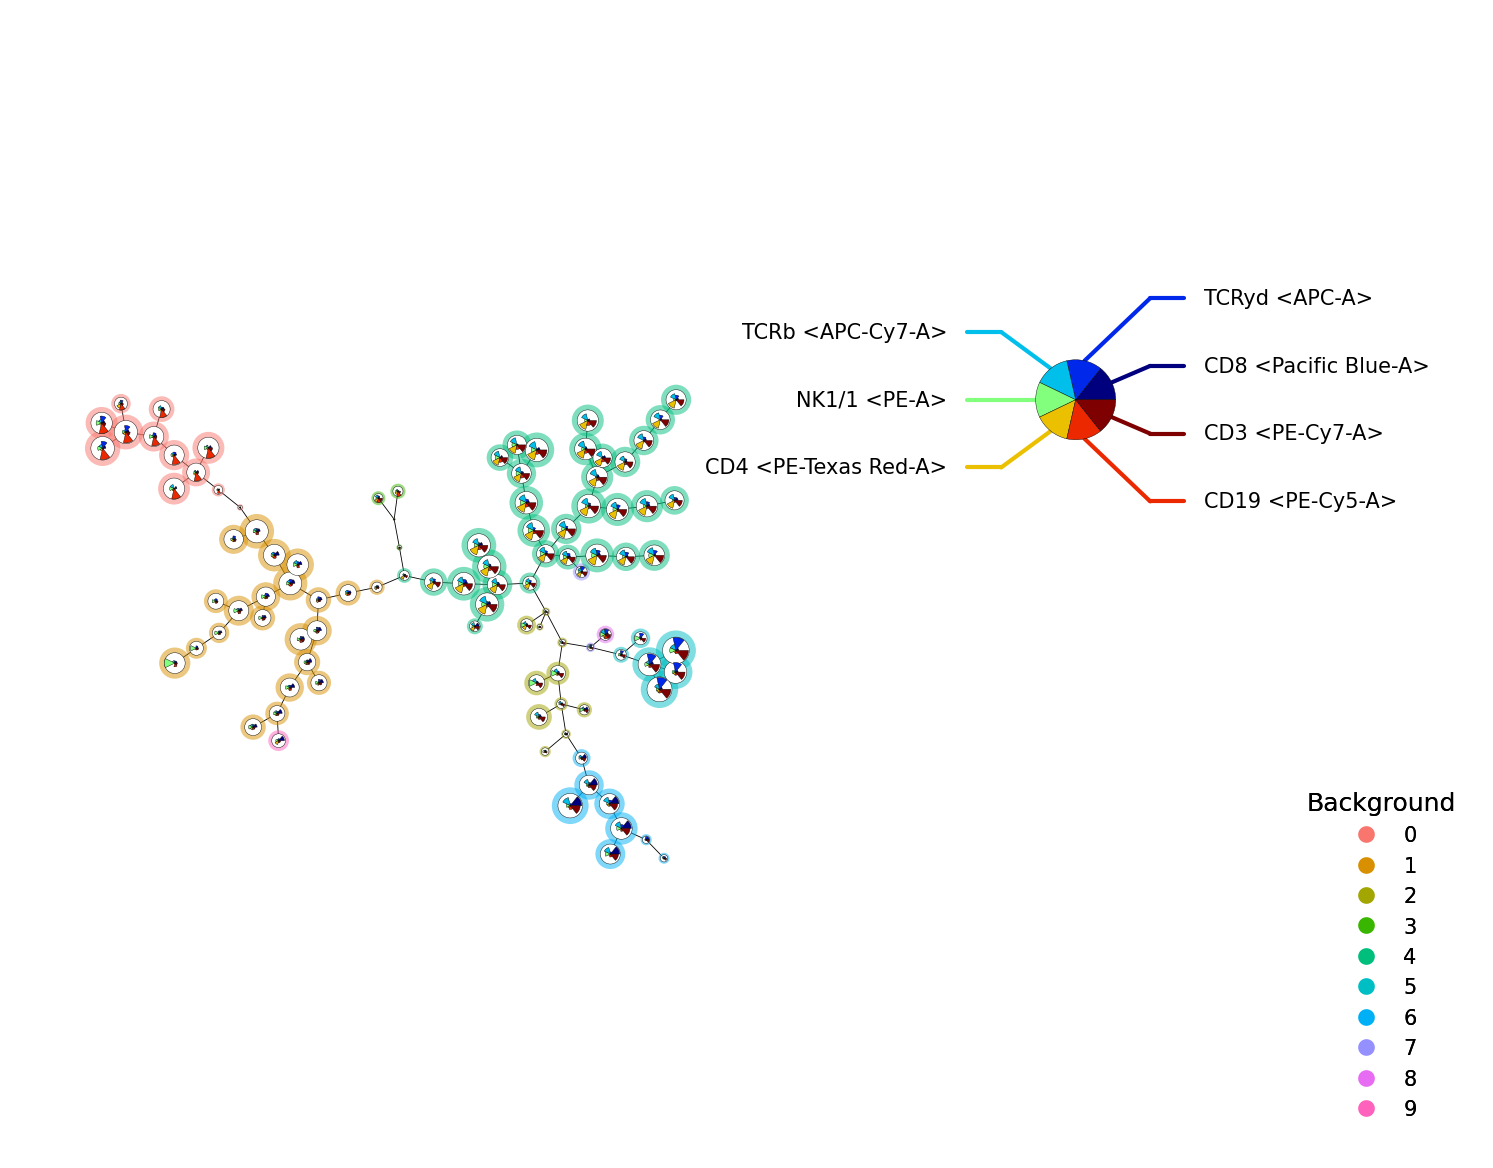

In [57]:
p = fs.pl.plot_stars(fsom, background_values=fsom.get_cluster_data().obs.metaclustering)

We can also visualize the grid, to reduce overlap and get a better view of the data.
The node sizes of the nodes and/or the background nodes can be made equal with the equal_node_size or equal_background_size argument


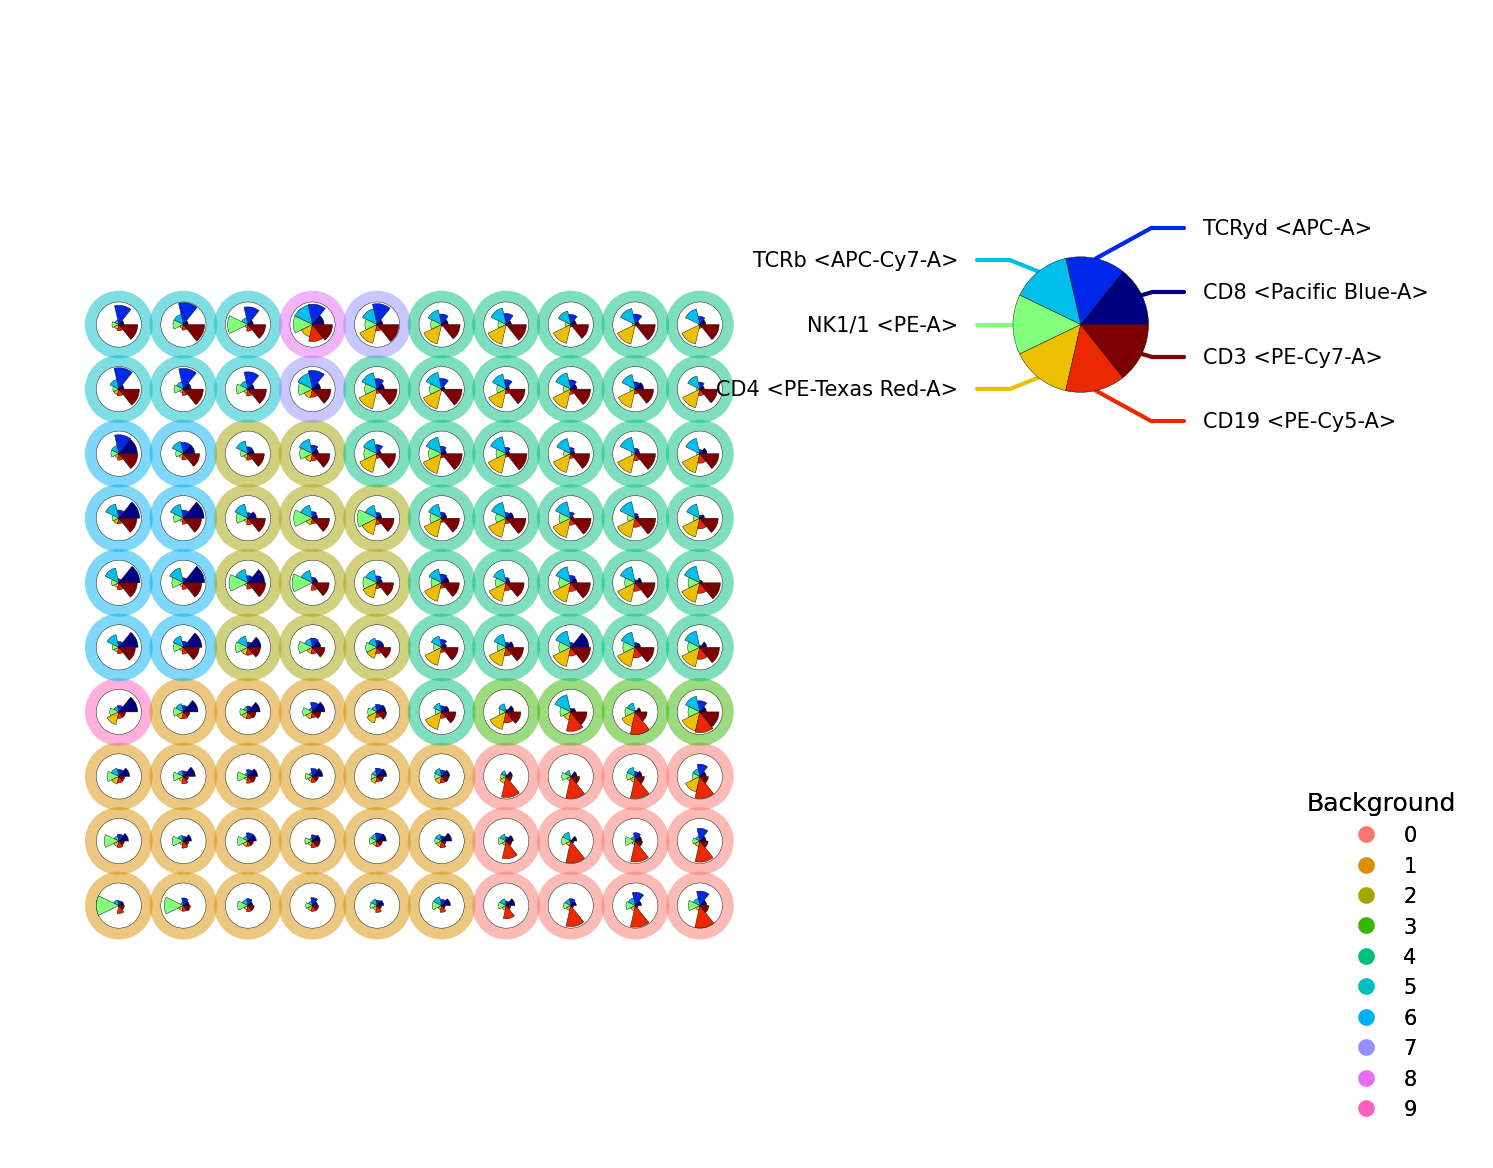

In [58]:
p = fs.pl.plot_stars(
    fsom,
    background_values=fsom.get_cluster_data().obs.metaclustering,
    view="grid",
    equal_node_size=True,
    equal_background_size=True,
)

If you have a label for every cell, we can visualize this with `plot_pies()`.
Here every node is a piechart with the percentage of cells in each cluster.


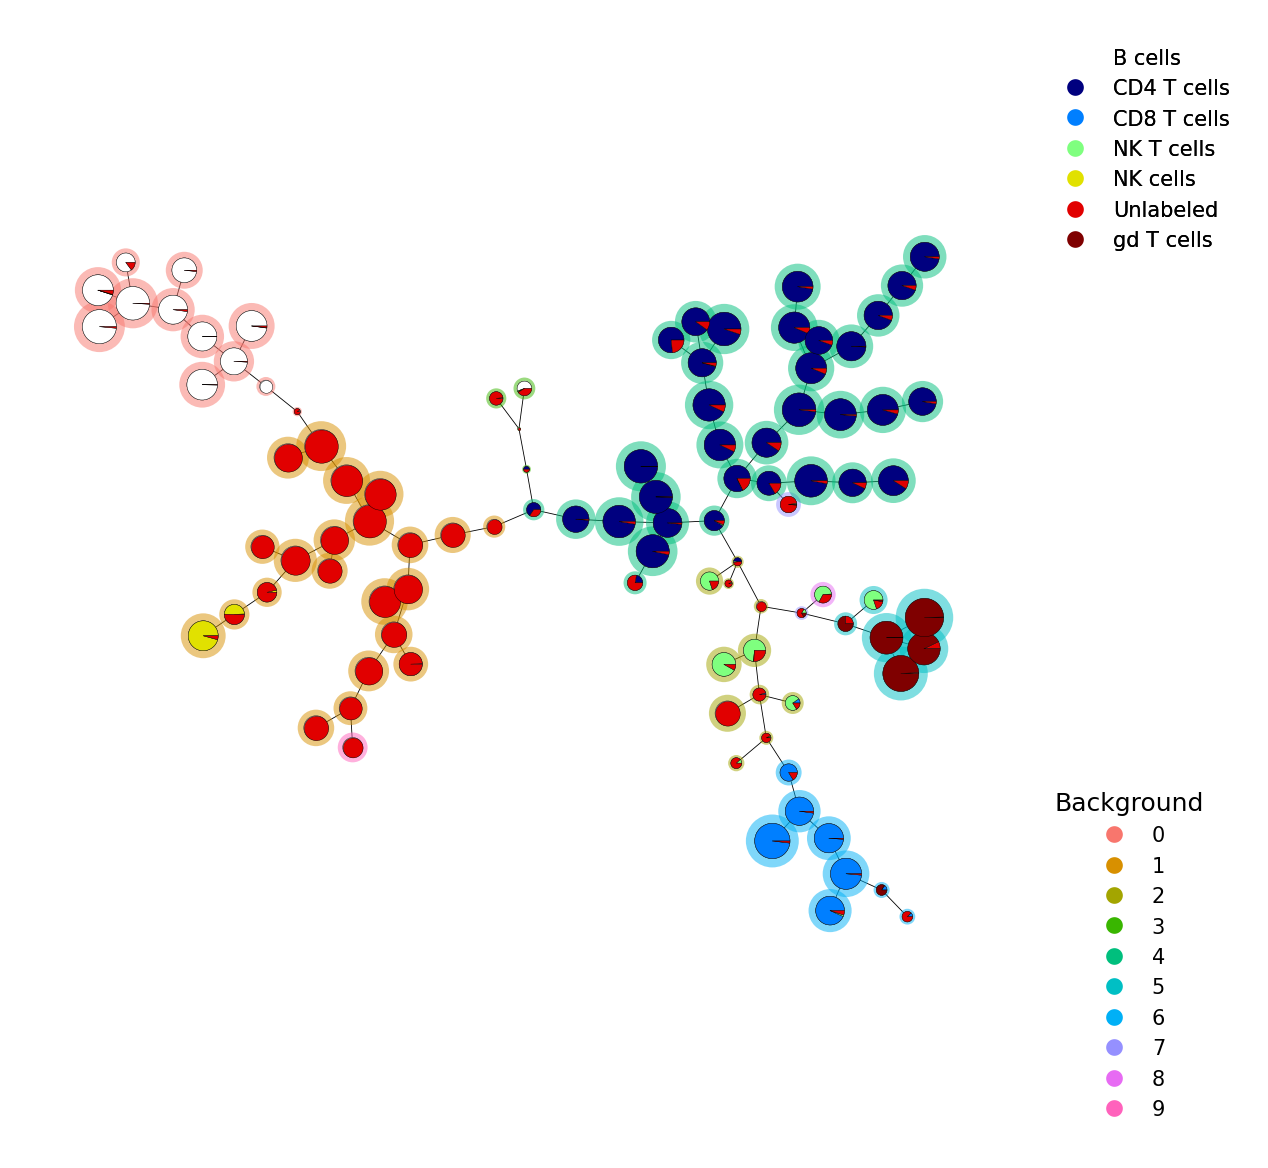

In [59]:
# Read in that data
file = open("../../tests/data/gating_result.csv")
data = csv.reader(file)
data = [i[0] for i in data]

# Plot
p = fs.pl.plot_pies(fsom, data, background_values=fsom.get_cluster_data().obs.metaclustering)

We can also visualize the cluster numbers or metacluster numbers with the help of
`plot_numbers()`, if `level="clusters"` or `level="metaclusters"`, respectively.
This functions uses `plot_labels()` internally, to which one can pass custom labels,
such as the cell type labels.


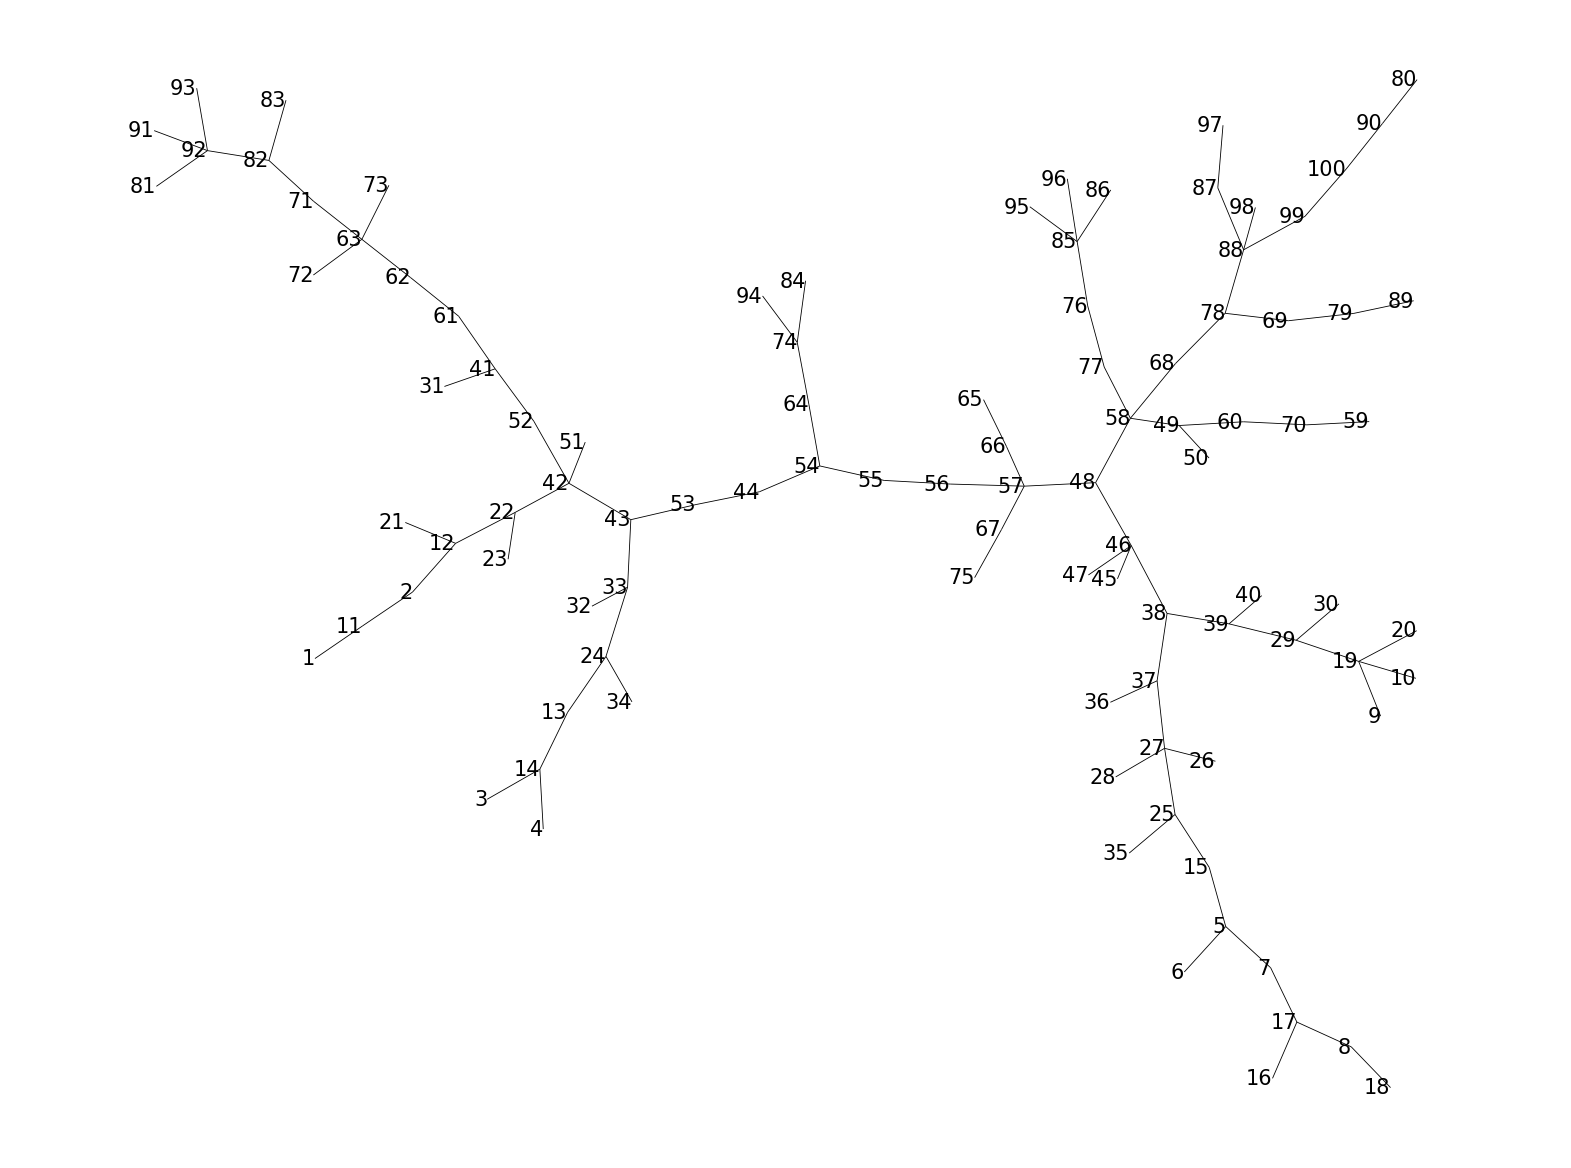

In [60]:
p = fs.pl.plot_numbers(fsom, level="clusters", text_size=5)

It is possible to visualize one marker on a FlowSOM tree with the `plot_marker()`
function. This function uses the `plot_variable()` function internally, to which
one can pass custom variables, such as the cell type labels.


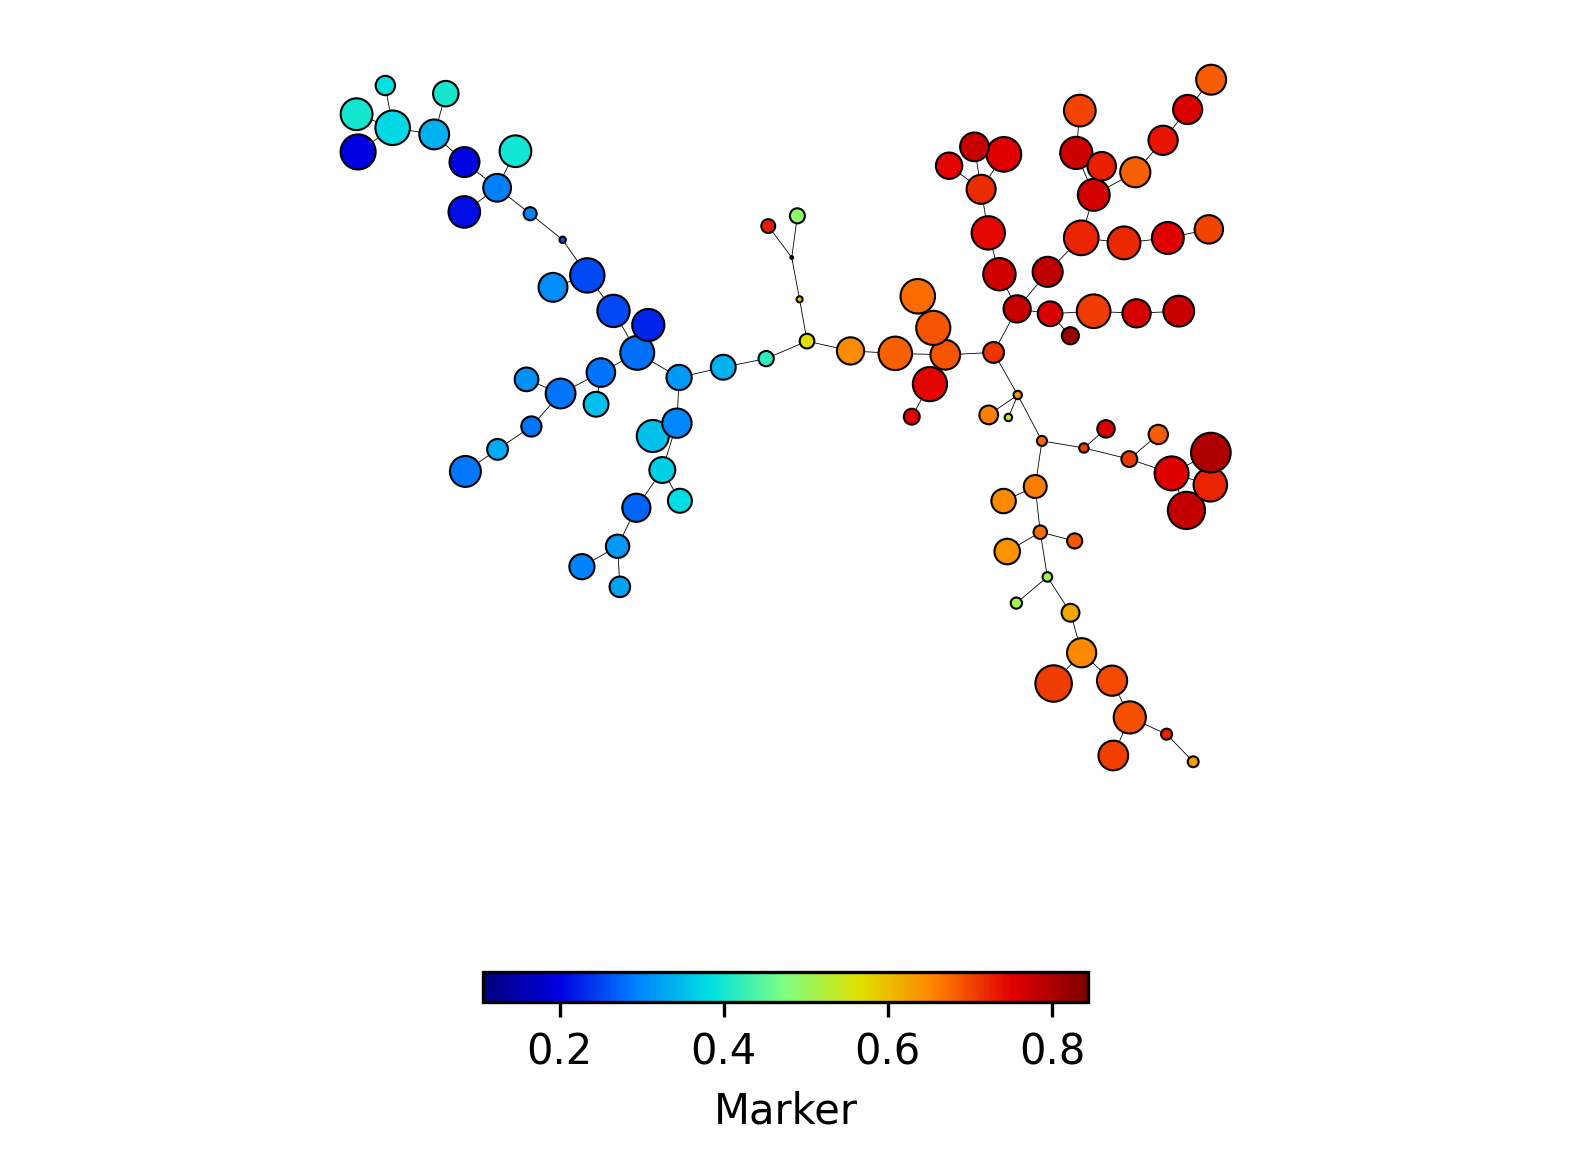

In [61]:
p = fs.pl.plot_marker(fsom, marker=np.array(["CD3"]))

We can also visualize the clusters and metaclusters on a 2D scatter plot with
`plot_2D_scatters()`.


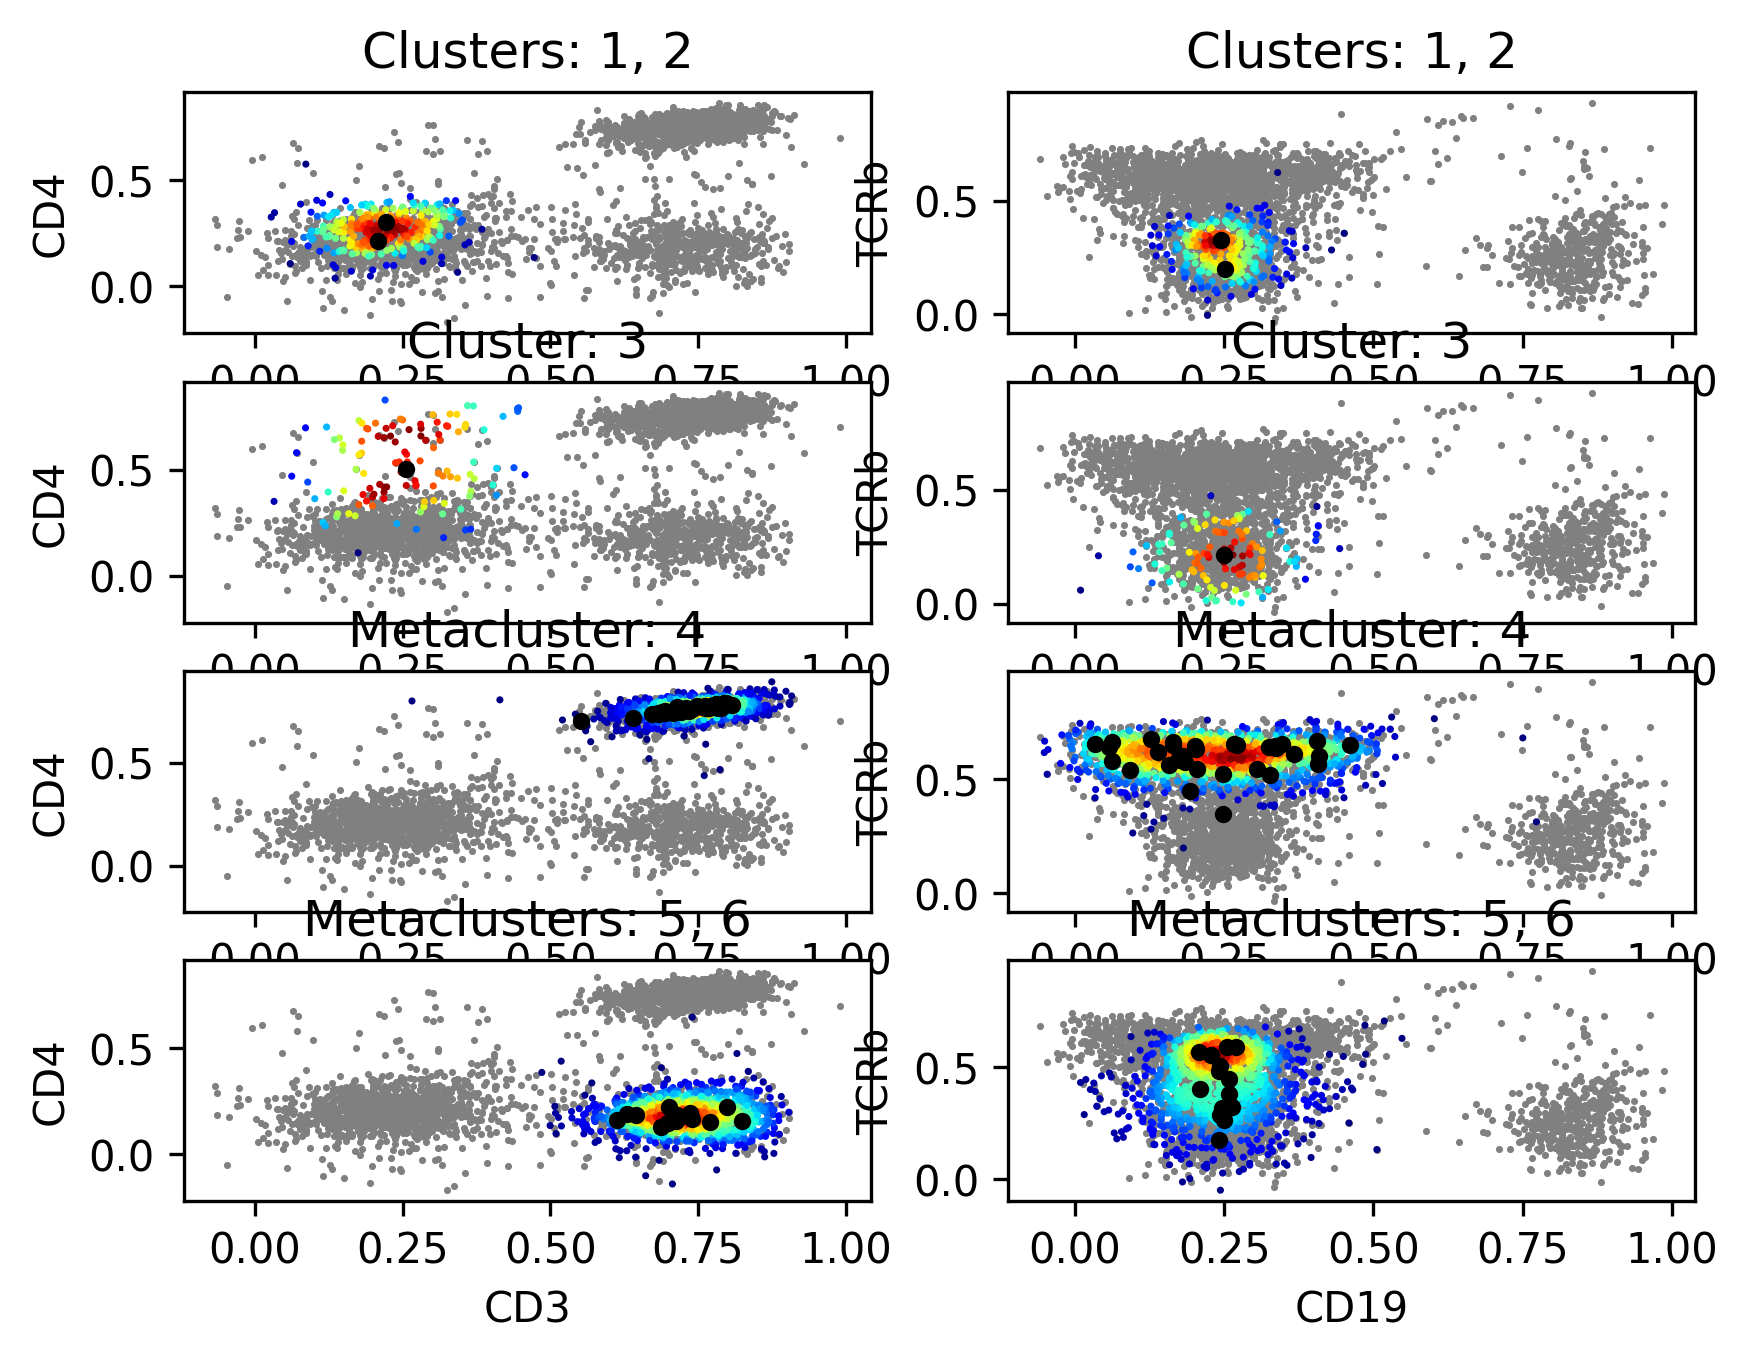

In [62]:
p = fs.pl.plot_2D_scatters(
    fsom,
    channelpairs=[["CD3", "CD4"], ["CD19", "TCRb"]],
    clusters=[[1, 2], [3]],
    metaclusters=[[4], [5, 6]],
    density=True,
    centers=True,
)

# Downstream analysis

We might need the percentages, counts or the percentages
of positive cells per cluster or metacluster and per file for further analysis.
This can be done with the `get_features()` function. This function returns a
dictionary containing pandas of the requested data.


In [63]:
features = fs.tl.get_features(
    fsom,
    files=[ff_t[1:1000, :], ff_t[1000:2000, :]],
    level=["clusters", "metaclusters"],
    type=["counts", "percentages"],
)
features["metacluster_percentages"]

/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/benjaminr/Documents/GitHub/FlowSOM/src/flowsom/main.py:164: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["pretty_colnames"] = np.asarray(pretty_colnames, dtype=str)
/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/benjaminr/Documents/GitHub/FlowSOM/src/flowsom/main.py:164: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["pretty_colnames"] = np.asarray(pretty_colnames, dtype=str)


MC0       MC1       MC2       MC3      MC4       MC5       MC6  \
0  0.134134  0.253253  0.038038  0.007007  0.38038  0.088088  0.087087   
1  0.133000  0.227000  0.038000  0.003000  0.40100  0.090000  0.099000   

        MC7       MC8       MC9  
0  0.009009  0.002002  0.001001  
1  0.001000  0.004000  0.004000

The counts, percentages, percentages_positive, per cluster or metacluser can also
extracted from a FlowSOM object. For this we can use `get_counts()`, `get_percentages()`,
`get_cluster_percentages_positive()` or `get_metacluster_percentages_positive`, respectively.


In [64]:
fs.tl.get_counts(fsom, level="clusters")

counts
C0      258
C1      110
C2      171
C3      114
C4      230
..      ...
C95     222
C96     271
C97     219
C98     245
C99     231

[100 rows x 1 columns]

At last it is also possible to visualize a UMAP colored by the metaclustering or the expression of a marker. For this we will use `scanpy`.


In [65]:
# Get subset of the cell data
ref_markers_bool = fsom.get_cell_data().var["cols_used"]
subset_fsom = fsom.get_cell_data()[
    np.random.choice(range(fsom.get_cell_data().shape[0]), 5000, replace=False),
    fsom.get_cell_data().var_names[ref_markers_bool],
]
sc.pp.neighbors(subset_fsom)
sc.tl.umap(subset_fsom)

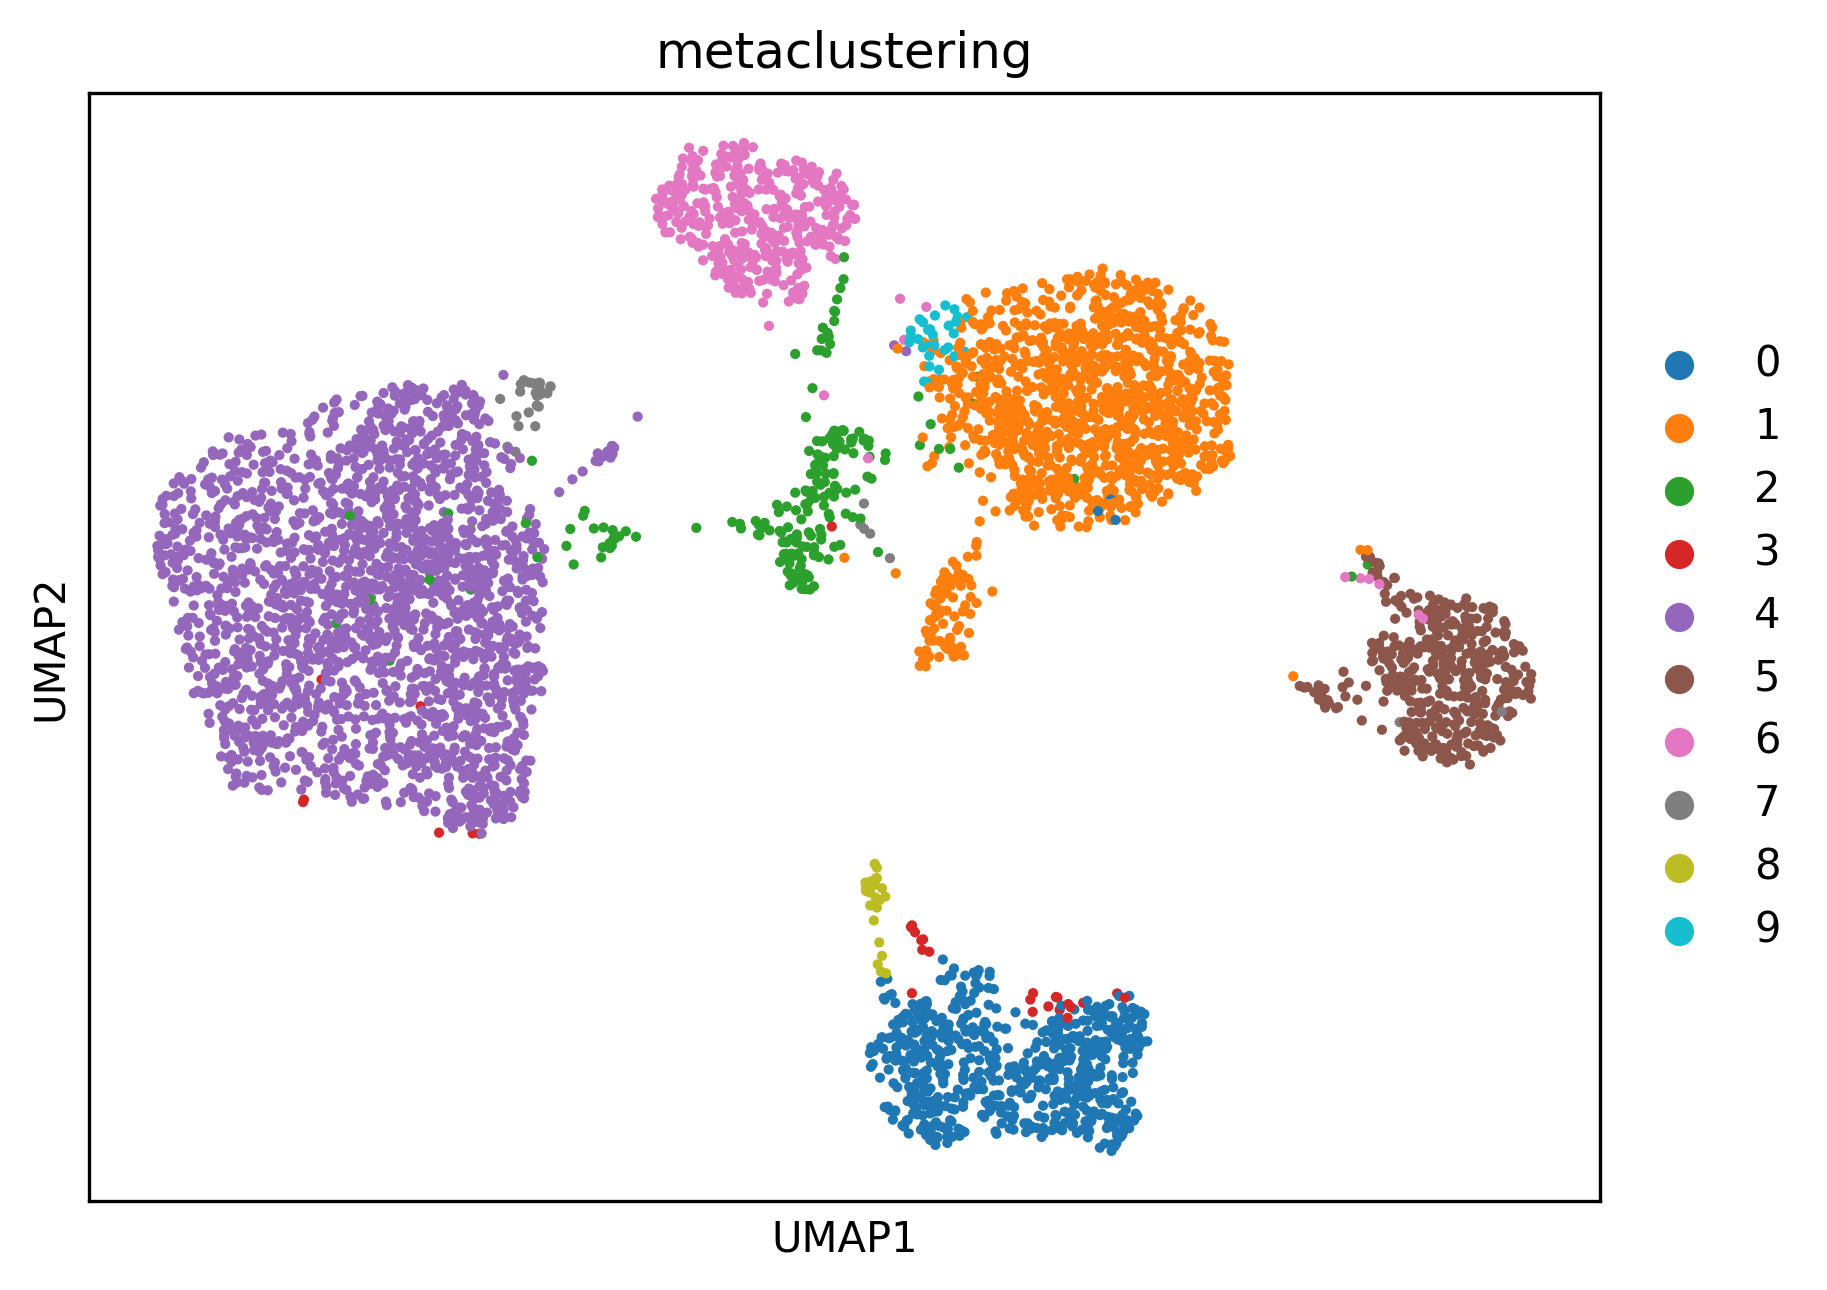

In [66]:
# By metaclustering
subset_fsom.obs["metaclustering"] = subset_fsom.obs["metaclustering"].astype(str)
sc.pl.umap(subset_fsom, color="metaclustering")

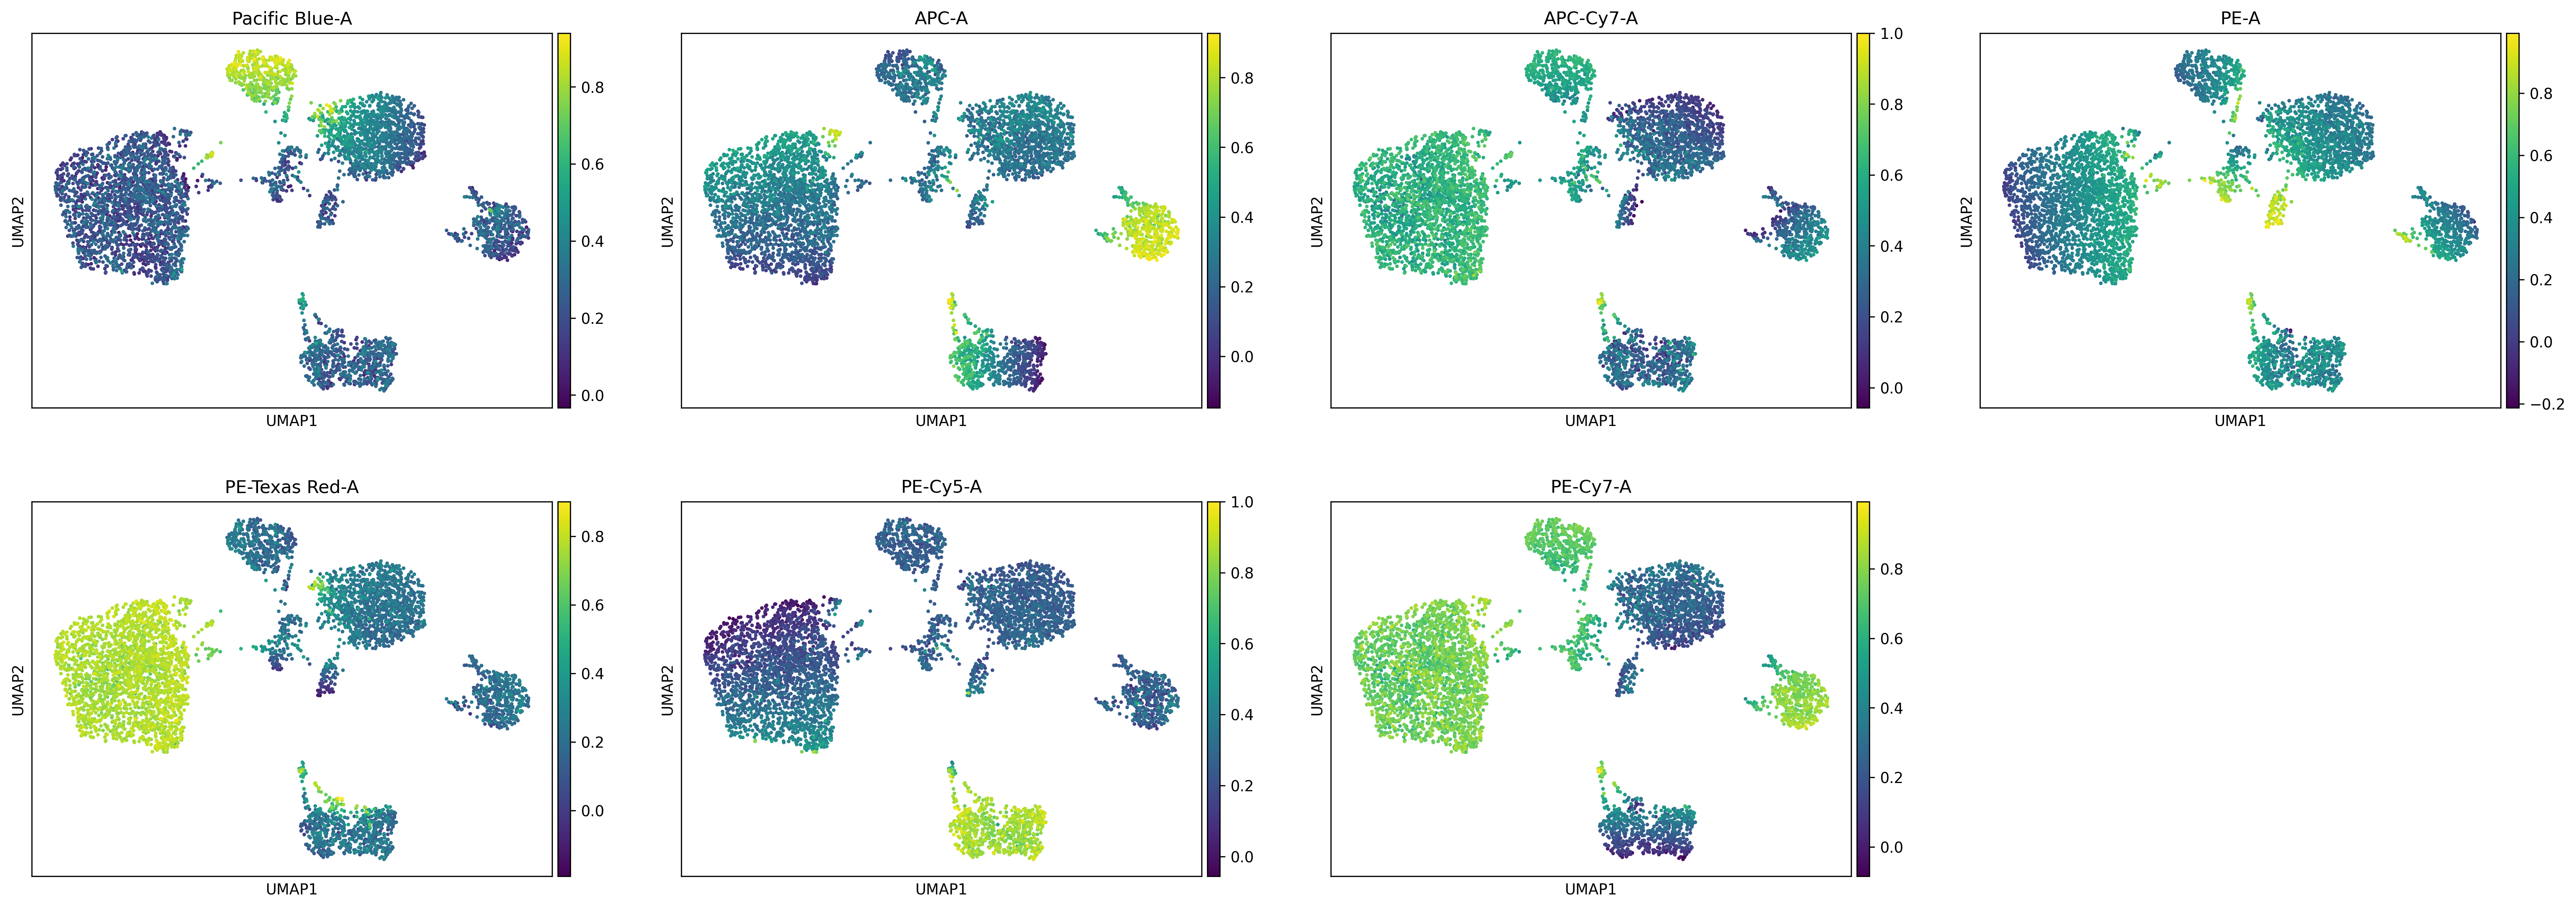

In [67]:
# By markers
sc.pl.umap(subset_fsom, color=fsom.get_cell_data().var_names[ref_markers_bool])

# Other interesting functions

To get the markers or channels from the corresponding channels or markers of an FCS or a FlowSOM object, we can use `get_markers()` or `get_channels()`.

newdata
subset


In [68]:
fs.tl.get_channels(ff_t, np.array(["CD3", "CD4"]))

{'PE-Cy7-A': 'CD3', 'PE-Texas Red-A': 'CD4'}

In [69]:
fs.tl.get_markers(fsom, np.array(["PE-A", "PE-Cy7-A"]))

{'NK1/1': 'PE-A', 'CD3': 'PE-Cy7-A'}

We can also merge multiple FCS files with random subsampling
with the function `aggregate_flowframes()`.


In [70]:
fs.pp.aggregate_flowframes(
    filenames=[
        "../../tests/data/not_preprocessed.fcs",
        "../../tests/data/not_preprocessed.fcs",
    ],
    c_total=5000,
)

/Users/benjaminr/Documents/GitHub/FlowSOM/src/flowsom/pp/fcs_functions.py:47: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs["Original_ID"] = np.array(ids, dtype=np.float32)
/Users/benjaminr/Documents/GitHub/FlowSOM/src/flowsom/pp/fcs_functions.py:47: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  f.obs["Original_ID"] = np.array(ids, dtype=np.float32)
/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 5000 × 18
    obs: 'Original_ID', 'File', 'File_scattered'
    uns: 'meta'

To map new data on an existing FlowSOM object, we can use the `new_data()` function.


/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/Users/benjaminr/Documents/GitHub/FlowSOM/src/flowsom/main.py:164: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["pretty_colnames"] = np.asarray(pretty_colnames, dtype=str)


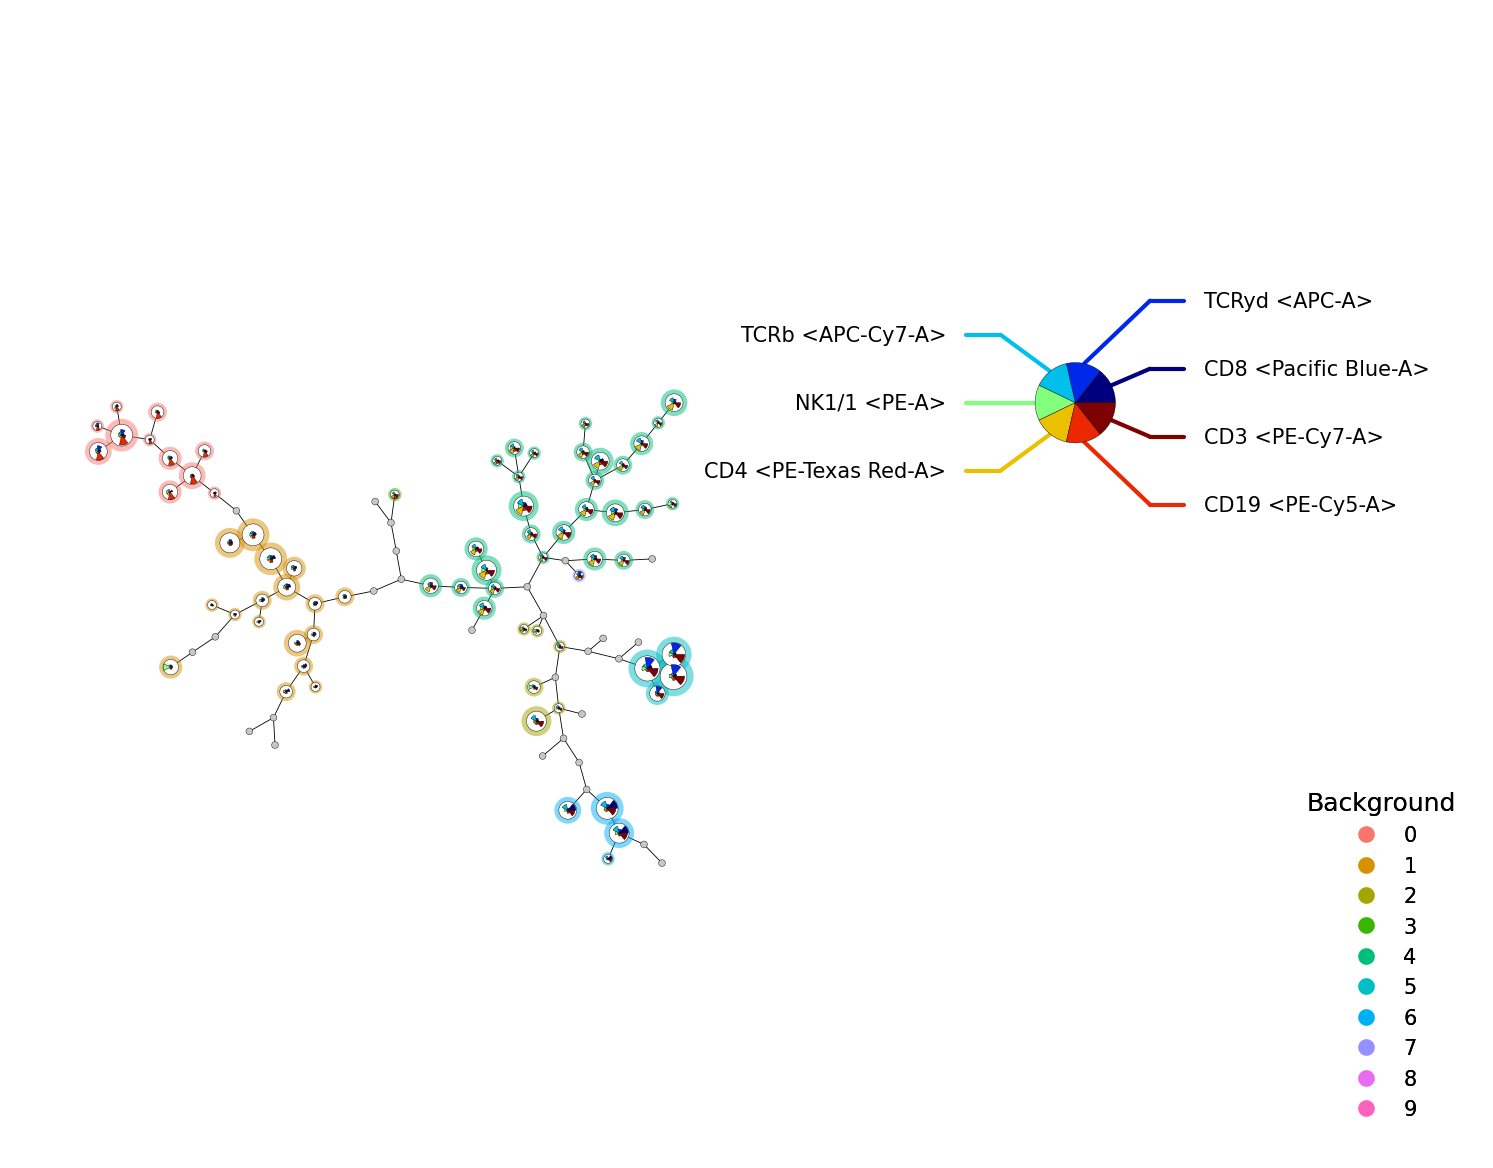

In [71]:
fsom_new = fsom.new_data(ff_t[1:200, :])
p = fs.pl.plot_stars(fsom_new, background_values=fsom_new.get_cluster_data().obs.metaclustering)

We can also take a subset of a FlowSOM object. For this we use the `subset()` function.


/opt/homebrew/Caskroom/mambaforge/base/envs/flowsom/lib/python3.12/site-packages/mudata/_core/mudata.py:489: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


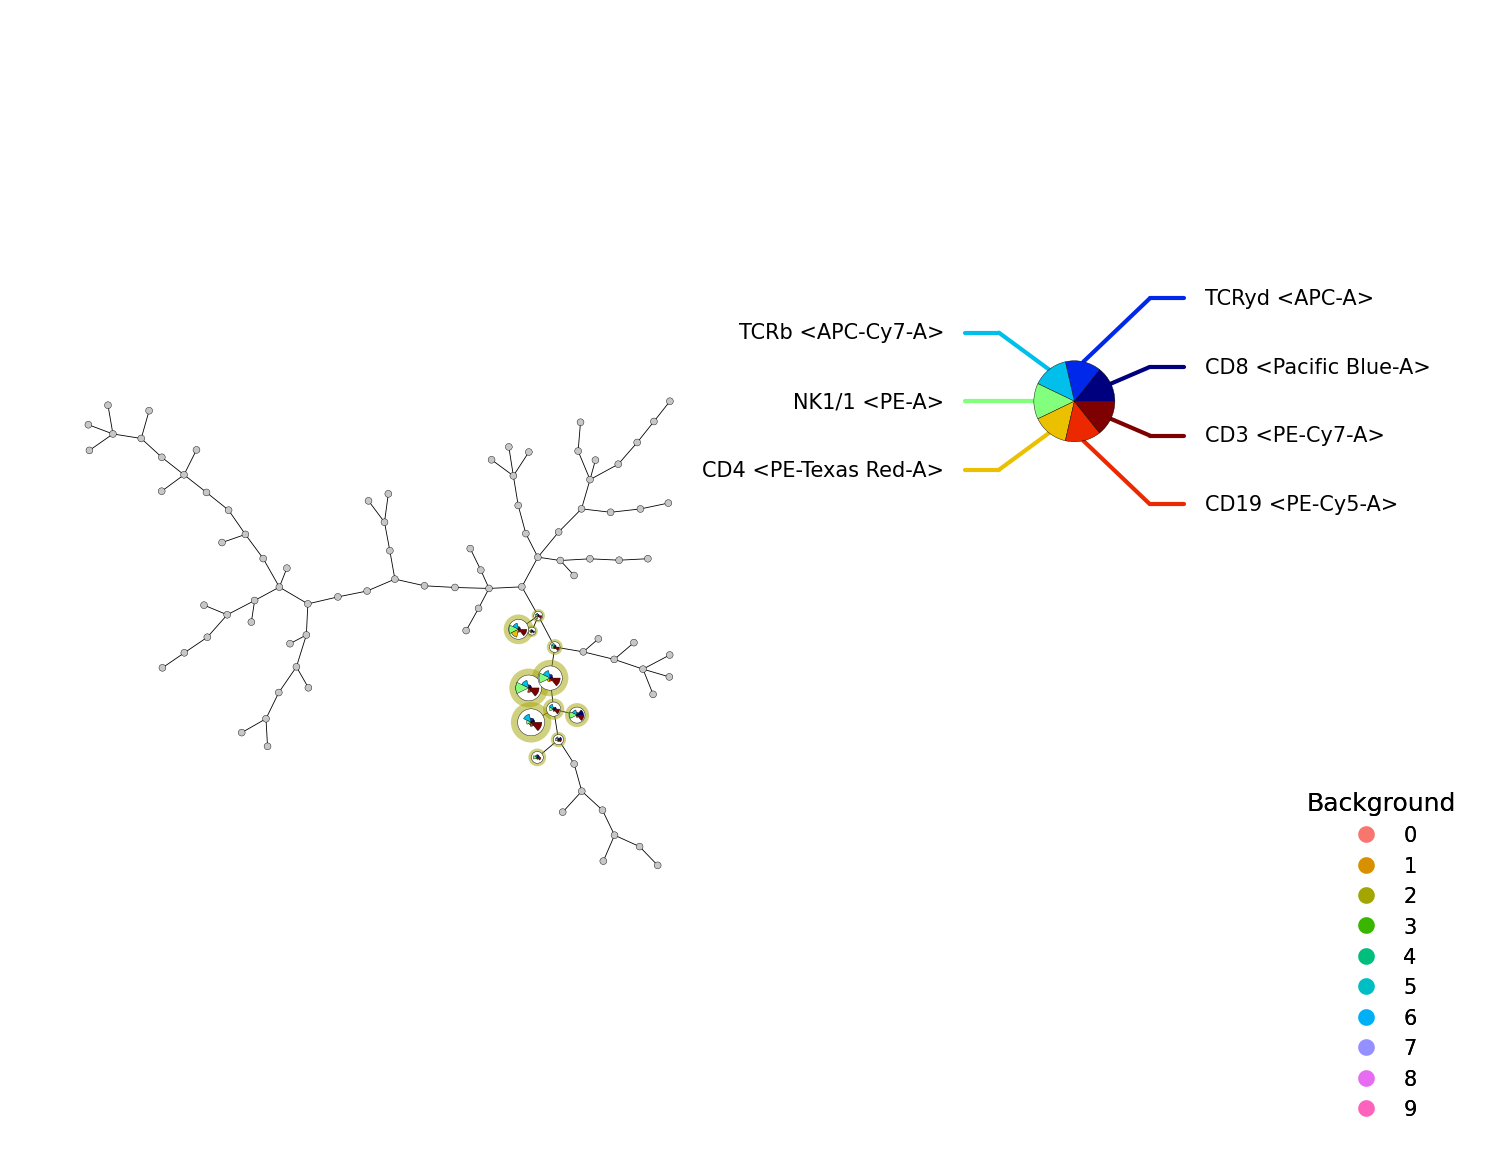

In [72]:
fsom_subset = fsom.subset(fsom.get_cell_data().obs["metaclustering"] == 2)
p = fs.pl.plot_stars(fsom_subset, background_values=fsom_subset.get_cluster_data().obs.metaclustering)

In [73]:
import session_info2

session_info2.session_info(dependencies=True)

anndata	0.10.8
pytometry	0.1.6
scanpy	1.10.4
numpy	1.26.4
matplotlib	3.10.0
pandas	2.2.3
mudata	0.2.4
----	----
python-dateutil	2.9.0.post0
pure_eval	0.2.3
decorator	5.1.1
scipy	1.12.0
jedi	0.19.1
FlowUtils	1.1.0
matplotlib-inline	0.1.7
pyzmq	26.2.0
traitlets	5.14.3
Pygments	2.18.0
six	1.17.0
cloudpickle	3.0.0
packaging	24.2
sphinxcontrib-htmlhelp	2.1.0
sphinxcontrib-qthelp	2.0.0
kiwisolver	1.4.8
llvmlite	0.44.0
asttokens	2.4.1
cycler	0.12.1
toolz	0.12.1
scikit-learn	1.6.1
psutil	6.0.0
igraph	0.11.8
comm	0.2.2
parso	0.8.4
seaborn	0.13.2
consensusclustering	0.2.3
appnope	0.1.4
jupyter_client	8.6.3
pytz	2024.2
debugpy	1.8.6
platformdirs	4.3.6
texttable	1.7.0
kneed	0.8.5
executing	2.1.0
h5py	3.12.1
natsort	8.4.0
sphinxcontrib-applehelp	2.0.0
pyparsing	3.2.1
Jinja2	3.1.4
sphinxcontrib-devhelp	2.0.0
sphinxcontrib-jsmath	1.0.1
jupyter_core	5.7.2
session-info2	0.1.2
pyarrow	15.0.2
patsy	1.0.1
MarkupSafe	2.1.5
dask	2024.6.2
pillow	11.1.0
sphinxcontrib-serializinghtml	2.0.0
threadpoolctl	3.5.0
fcsparser	0.2.8
ipywidgets	8.1.2
coverage	7.4.4
ipykernel	6.29.5
tornado	6.4.1
statsmodels	0.14.4
readfcs	1.1.9
fonttools	4.55.5
MiniSom	2.3.3
joblib	1.4.2
tqdm	4.67.1
loguru	0.7.3
umap-learn	0.5.7
ipython	8.27.0
sphinxcontrib-bibtex	2.6.3
numba	0.61.0
setuptools	75.1.0
pynndescent	0.5.13
PyYAML	6.0.2
stack-data	0.6.3
prompt_toolkit	3.0.48
legacy-api-wrap	1.4.1
wcwidth	0.2.13
----	----
Python	3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
OS	macOS-15.4-arm64-arm-64bit
Updated	2025-04-17 07:15